In [210]:
import os
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [211]:
BASE_DIR = '..'
RESULTS_DIR = os.path.join(BASE_DIR,'cami2_benchmark', 'model_results', 'parsed_results')
OUT_DIR = os.path.join(BASE_DIR, 'figures')

## CheckM2 Results

In [217]:
with open(os.path.join(RESULTS_DIR, 'parsed_checkm2_results.json'), 'r') as f:
    checkm2_data = json.load(f)

In [ ]:
import matplotlib.pyplot as plt

completeness_levels = ['>90%', '>80%', '>70%', '>60%', '>50%']
colors = ['#005f5f', '#008c8c', '#66c2c2', '#a0e6e6', '#d9fafa']

dataset_order = [
    'airways_short',
    'gastro_short',
    'oral_short',
    'urogenital_short',
    'skin_short',
    'marine_short',
    'plant_short'
]

model_names = {
    'vamb_results': 'VAMB',
    'taxvamb_results': 'TaxVAMB',
    'comebin_results': 'Comebin',
    'dnaberts_results': 'DNABERT-S',
    'dnabert2_results': 'DNABERT-2',
    'dnabert2random_results': 'DNABERT2-Random',
    'tnf_results': 'TNF',
    'tnfkernel_results': 'TNF-Kernel',
    'dna2vec_results': 'DNA2Vec'
}

C:\Users\ah140\AppData\Local\Temp\ipykernel_14120\3069013795.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


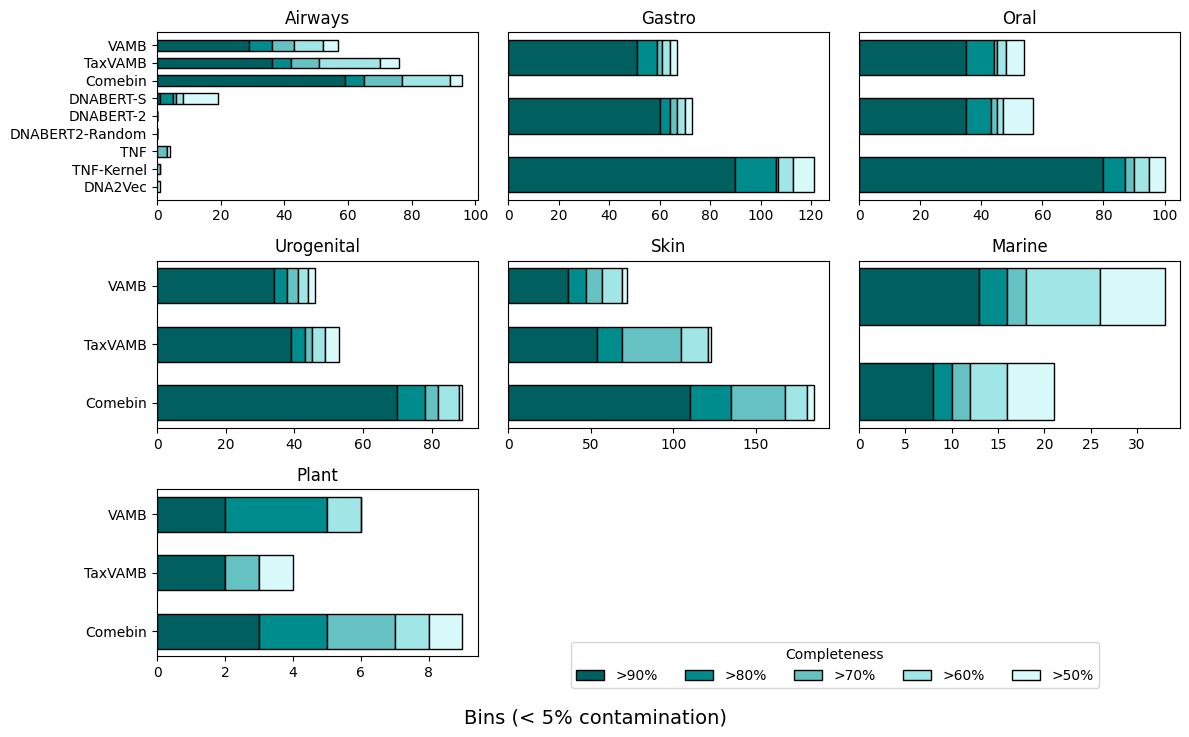

In [216]:
n_cols = 3
n_rows = int((len(dataset_order) + n_cols - 1) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 7), constrained_layout=True)
axes = axes.flatten()

max_total = 0

for idx, domain in enumerate(dataset_order):
    methods = checkm2_data[domain]
    
    # Filter and sort method names based on custom order
    method_names = [m for m in model_names.keys() if m in methods]
    y_pos = list(range(len(method_names)))
    
    left = [0] * len(method_names)
    ax = axes[idx]
    
    for i, comp in enumerate(completeness_levels):
        if i == 0:
            values = [methods[m][i] for m in method_names]
        else:
            values = [methods[m][i] - methods[m][i - 1] for m in method_names]
        
        ax.barh(y_pos, values, left=left, color=colors[i], edgecolor='black', height=0.6)
        left = [l + v for l, v in zip(left, values)]

    ax.set_title(domain.replace('_short', '').capitalize())

    if idx % n_cols == 0:
        ax.set_yticks(y_pos)
        ax.set_yticklabels([model_names.get(m, m.replace('_results', '')) for m in method_names])
    else:
        ax.set_yticks(y_pos)
        ax.set_yticklabels([])
        ax.tick_params(left=False)

    ax.invert_yaxis()
    max_total = max(max_total, max(left))


# Remove any unused subplots
for i in range(len(dataset_order), len(axes)):
    fig.delaxes(axes[i])

# Add legend and bottom title
fig.legend(completeness_levels, loc='lower center', ncol=5, bbox_to_anchor=(0.7, 0), title='Completeness')
fig.text(0.5, -0.04, "Bins (< 5% contamination)", fontsize=14, ha='center')

plt.tight_layout()
plt.show()

## KNN Histograms

In [162]:
with open(os.path.join(RESULTS_DIR, 'parsed_knn_histograms.json'), 'r') as f:
    knn_data = json.load(f)

In [163]:
def modify_histogram_data(dataset_dict):
    """
    Adds a 0 and 1 to the start and end of the pairsim_vector and bin_vector
    """
    
    for dataset_name, models in dataset_dict.items():
        for model_name, model_data in models.items():
            # Modify pairsim_vector by adding 0 at the start and 1 at the end
            if "pairsim_vector" in model_data:
                model_data["pairsim_vector"] = [0] + model_data["pairsim_vector"] + [1]
            
            # Modify bin_vector by adding 0 at both the start and end
            if "bin_vector" in model_data:
                model_data["bin_vector"] = [0] + model_data["bin_vector"] + [0]

    return dataset_dict

In [201]:
def plot_histograms(dataset_dict, selected_models: list, selected_model_names:list):
    """
    Plots histograms for the selected models of each dataset.

    Args:
        dataset_dict (dict): Dictionary where the key is the dataset name and value is a 
                             dictionary of models and associated histogram data.
    """
    dataset_dict = modify_histogram_data(dataset_dict)
    color_thres = 'darkred'
    n_datasets = len(dataset_dict)
    n_models = len(selected_models)

    fig, axes = plt.subplots(n_datasets, n_models, figsize=(12, 4 * n_datasets), squeeze=False)

    for i, (dataset_name, models) in enumerate(dataset_dict.items()):
        for j, (model_name, model_namepretty) in enumerate(zip(selected_models, selected_model_names)):

            ax = axes[i, j]

            x_data = models[model_name].get("pairsim_vector", None)
            y_data = models[model_name].get("bin_vector", None)
            threshold = models[model_name].get("knn_threshold", None)
            k = models[model_name].get("k", None)
            p = models[model_name].get("p", None)

            #histogram
            ax.plot(x_data, y_data, color='steelblue', linestyle='-', linewidth=2)
            ax.fill_between(x_data, y_data, color='steelblue', alpha=0.3)

            # Add k, p box
            ax.text(
                0.04, 0.96, f'k={k}, p={p}', 
                transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='gray', alpha=0.6)
            )

            # Threshold line and annotation
            ax.axvline(threshold, color=color_thres, linestyle='--', label=f'Threshold: {threshold:.2f}')
            if model_name in ['aa']:
                ax.text(threshold + 0.04, 0.8 * max(ax.get_ylim()), f'{threshold:.2f}', color=color_thres, fontsize=11, ha='left')
                ax.plot([threshold + 0.04, threshold + 0.04 + 0.11], [0.78 * max(ax.get_ylim())] * 2, color=color_thres, lw=1)
            else:
                ax.text(threshold - 0.09, 0.8 * max(ax.get_ylim()), f'{threshold:.2f}', color=color_thres, fontsize=11, ha='center')
                ax.plot([threshold - 0.04, threshold - 0.04 - 0.11], [0.78 * max(ax.get_ylim())] * 2, color=color_thres, lw=1)

            # Y-axis formatting
            y_min, y_max = ax.get_ylim()
            y_ticks = np.linspace(y_min, y_max, 4)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{tick / 100:.5f}' for tick in y_ticks])
            ax.grid(True, linestyle='--', alpha=0.5)

            # Add column titles
            if i == 0:
                ax.set_title(model_namepretty, fontsize=13, pad=12)

        # Add row labels on the far left
        fig.text(-0.01, (1 - (i + 0.5) / n_datasets), dataset_name.replace('_short','').capitalize(), ha='left', va='center', fontsize=13, rotation='vertical')

    fig.supxlabel('Similarity', fontsize=16)
    fig.supylabel('Density', fontsize=16)

    plt.tight_layout()
    plt.show()

In [202]:
models = ['dnaberts', 'dnabert2', 'dnabert2random', 'tnf', 'tnfkernel', 'dna2vec']
model_names = ['DNABERT-S', 'DNABERT-2', 'DNABERT2-Random', 'TNF', 'TNF-Kernel', 'DNA2Vec']

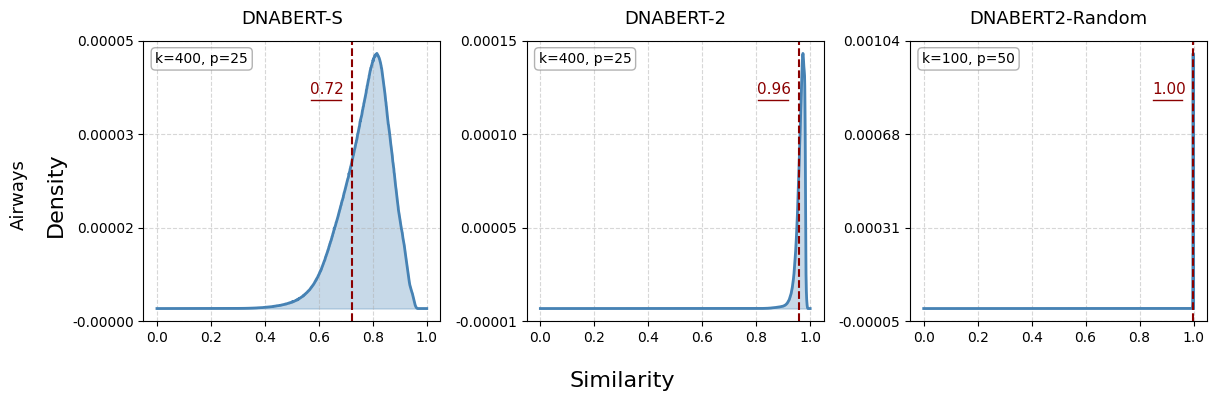

In [203]:
plot_histograms(knn_data, models[:3], model_names[:3])

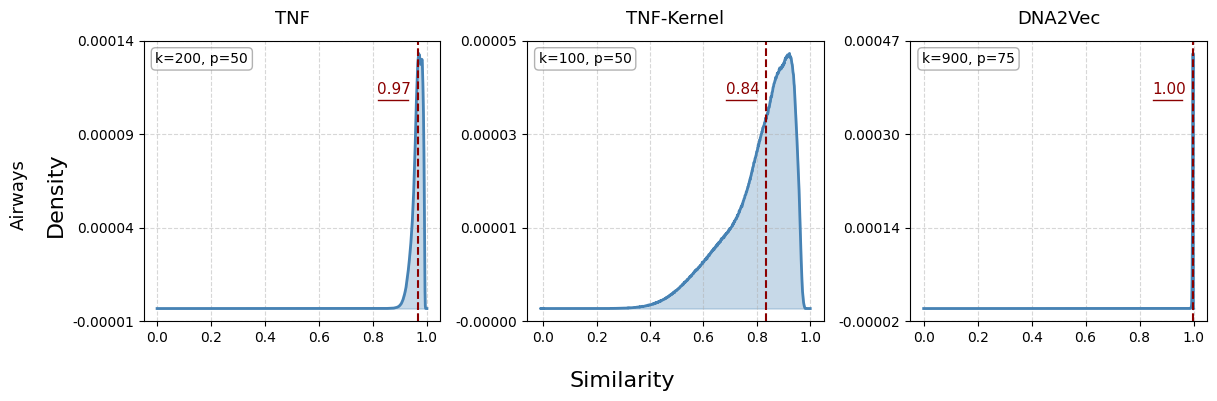

In [204]:
plot_histograms(knn_data, models[3:6], model_names[3:6])

## Contig length histograms

In [239]:
with open(os.path.join(RESULTS_DIR, 'parsed_contig_lengths.json'), 'r') as f:
    contig_data = json.load(f)

C:\Users\ah140\AppData\Local\Temp\ipykernel_14120\2632533070.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


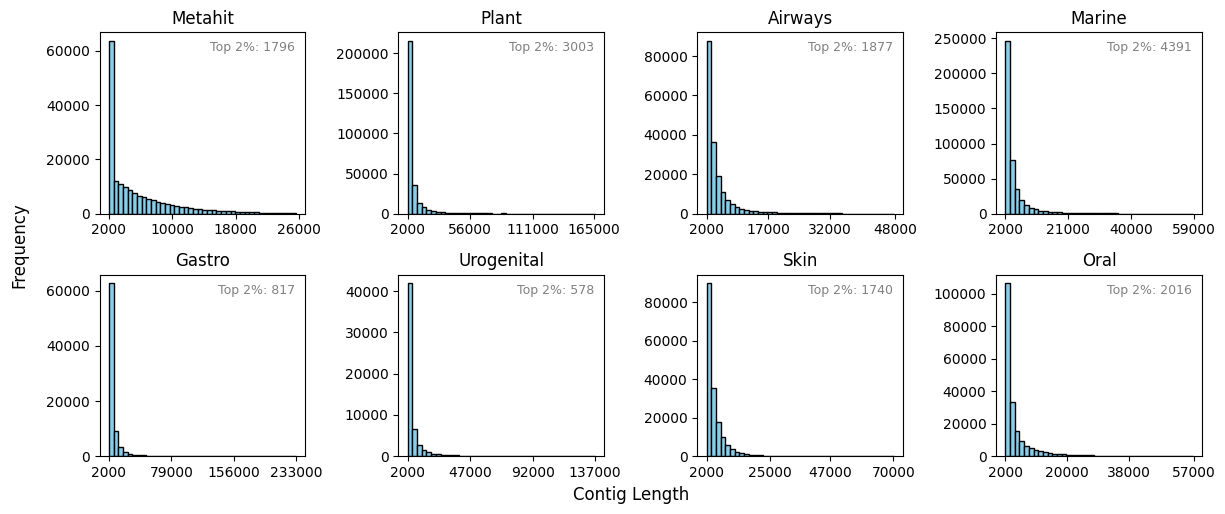

In [250]:
# Plot setup
n_cols = 4
n_rows = 2
percentile = 98
min_length = 2000

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for idx, (dataset, lengths) in enumerate(contig_data.items()):
    ax = axes[idx]
    top_1_percentile = np.percentile(lengths, 99)
    top_1_count = sum(l > top_1_percentile for l in lengths)
    ax.hist(lengths, bins=40, color='skyblue', range=(min_length, top_1_percentile), edgecolor='black')
    ax.set_title(dataset.replace('_short','').capitalize())
    ax.text(0.95, 0.95, f'Top {100-percentile}%: {top_1_count}', ha='right', va='top', transform=ax.transAxes, fontsize=9, color='grey')
    ticks = np.linspace(min_length, top_1_percentile, 4)  
    ticks = np.round(ticks / 1000) * 1000
    ax.set_xticks(ticks)
    
fig.text(0.5, 0.0, 'Contig Length', ha='center', va='center', fontsize=12)  # X-axis label
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=12) 

plt.tight_layout()
plt.show()